In [ ]:
cd /content/drive/My Drive

/content/drive/My Drive


In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 6.6MB 5.7MB/s 
     |████████████████████████████████| 2.2MB 11.2MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201009-cp36-none-any.whl size=43973 sha256=73f072c5ba12f28ebbb78377f8c243c5496576c942132bf4b9fcbdfa261f37b2
  Stored in directory: /root/.cache/pip/wheels/c4/6f/e5/e0fc4cc73c77dcf086e56570a3eaba64bf5f23d8088caa9fcf
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [ ]:
#Detectron2 is Facebook AI Research’s next generation software system that implements state-of-the-art object detection algorithms.



In [ ]:
#Either of them is a bit complicated to work with if we want to implement it from scratch. We need a framework where we can use state-of-the-art models such as Fast, Faster, and Mask R-CNNs with ease. Nevertheless, it is important to try building a model at least once from scratch to understand the math behind it.
#Detectron 2 comes to the rescue if we want to train an object detection model in a snap with a custom dataset.
#All the models present in the model zoo of the Detectron 2 library are pre-trained on COCO Dataset. We just need to fine-tune our custom dataset on the pre-trained model.

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo#Model Zoo API for Detectron2: a collection of functions to create common model architectures and optionally load pre-trained weights as released in MODEL_ZOO.md.
from detectron2.engine import DefaultPredictor#Create a simple end-to-end predictor with the given config that runs on single device for a single input image.
from detectron2.config import get_cfg #Detectron2 provides a key-value based config system that can be used to obtain standard, common behaviors.
from detectron2.utils.visualizer import Visualizer#Visualizer that draws data about detection/segmentation on images.
from detectron2.data import MetadataCatalog#This document explains how the dataset APIs (DatasetCatalog, MetadataCatalog) work, and how to use them to add custom datasets.Datasets that have builtin support in detectron2 are listed in builtin datasets. If you want to use a custom dataset while also reusing detectron2’s data loaders, you will need to:



In [ ]:
!wget https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz
!wget https://raw.githubusercontent.com/udacity/self-driving-car/master/annotations/labels_crowdai.csv

--2020-10-07 17:41:03--  https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.236.141
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.236.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1650810880 (1.5G) [application/x-gzip]
Saving to: ‘object-detection-crowdai.tar.gz’

object-detection-cr 100%[===================>]   1.54G  33.3MB/s    in 50s     

2020-10-07 17:41:53 (31.5 MB/s) - ‘object-detection-crowdai.tar.gz’ saved [1650810880/1650810880]

--2020-10-07 17:41:53--  https://raw.githubusercontent.com/udacity/self-driving-car/master/annotations/labels_crowdai.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7156250 (6.8M) [text/plain]
S

In [ ]:
!tar xf object-detection-crowdai.tar.gz

^C


In [ ]:
import pandas as pd

df = pd.read_csv('labels_crowdai.csv')

df.tail()

,xmin,ymin,xmax,ymax,Frame,Label,Preview URL
72059,958,559,1045,621,1479506176491553178.jpg,Car,http://crowdai.com/images/UpG-UBLnJWQkavSp/vis...
72060,1038,558,1122,630,1479506176491553178.jpg,Car,http://crowdai.com/images/UpG-UBLnJWQkavSp/vis...
72061,667,558,747,626,1479506176491553178.jpg,Car,http://crowdai.com/images/UpG-UBLnJWQkavSp/vis...
72062,730,568,818,613,1479506176491553178.jpg,Car,http://crowdai.com/images/UpG-UBLnJWQkavSp/vis...
72063,435,551,532,589,1479506176491553178.jpg,Car,http://crowdai.com/images/UpG-UBLnJWQkavSp/vis...


In [ ]:
df.head()

,xmin,ymin,xmax,ymax,Frame,Label,Preview URL
0,785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1,89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
2,268,546,383,650,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
3,455,522,548,615,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
4,548,522,625,605,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...


In [ ]:
len(df)

72064

In [ ]:
#This structure stores a list of boxes as a Nx4 torch.Tensor. It supports some common methods about boxes (area, clip, nonempty, etc), and also behaves like a Tensor (support indexing, to(device), .device, and iteration over all boxes)

In [ ]:

import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2
# write a function that loads the dataset into detectron2's standard format
def get_data_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['Frame'].map(lambda x: img_dir + x)

    classes = df['Label'].unique().tolist()

    df['class_int'] = df['Label'].map(lambda x: classes.index(x))

    dataset_dicts = []
    for filename in df['filename'].unique().tolist():
        record = {}
        
        #height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["height"] = 1200
        record["width"] = 1920

        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = df['Label'].unique().tolist()

DatasetCatalog.register('crowdai_vehicle_detection', lambda: get_data_dicts('labels_crowdai.csv' , 'object-detection-crowdai/'))
MetadataCatalog.get('crowdai_vehicle_detection').set(thing_classes=classes)
vehicle_detection_metadata = MetadataCatalog.get('crowdai_vehicle_detection')

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get('crowdai_vehicle_detection')
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=vehicle_detection_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()## obtain detectron2's default config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))#  # load values from a file
cfg.DATASETS.TRAIN = ('crowdai_vehicle_detection',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/09 04:18:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:06, 37.1MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.


[10/09 04:19:23 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


[10/09 04:19:37 d2.utils.events]:  eta: 0:11:16  iter: 19  total_loss: 1.718  loss_cls: 1.108  loss_box_reg: 0.661  loss_rpn_cls: 0.026  loss_rpn_loc: 0.045  time: 0.6674  data_time: 0.0975  lr: 0.000400  max_mem: 3652M
[10/09 04:19:51 d2.utils.events]:  eta: 0:10:53  iter: 39  total_loss: 1.119  loss_cls: 0.365  loss_box_reg: 0.645  loss_rpn_cls: 0.028  loss_rpn_loc: 0.051  time: 0.6610  data_time: 0.0343  lr: 0.000799  max_mem: 3652M
[10/09 04:20:04 d2.utils.events]:  eta: 0:10:39  iter: 59  total_loss: 0.891  loss_cls: 0.288  loss_box_reg: 0.490  loss_rpn_cls: 0.016  loss_rpn_loc: 0.034  time: 0.6667  data_time: 0.0120  lr: 0.001199  max_mem: 3652M
[10/09 04:20:20 d2.utils.events]:  eta: 0:10:27  iter: 79  total_loss: 0.629  loss_cls: 0.209  loss_box_reg: 0.355  loss_rpn_cls: 0.024  loss_rpn_loc: 0.036  time: 0.7000  data_time: 0.1379  lr: 0.001598  max_mem: 3652M
[10/09 04:20:34 d2.utils.events]:  eta: 0:10:19  iter: 99  total_loss: 0.665  loss_cls: 0.245  loss_box_reg: 0.357  loss

In [ ]:
cd /content/drive/My Drive

/content/drive/My Drive


In [ ]:
pwd

'/content/drive/My Drive'

Saving a-street-scene-in-shangahi-china-showing-traffic-including-buses-trucks-A93N38.jpg to a-street-scene-in-shangahi-china-showing-traffic-including-buses-trucks-A93N38 (7).jpg


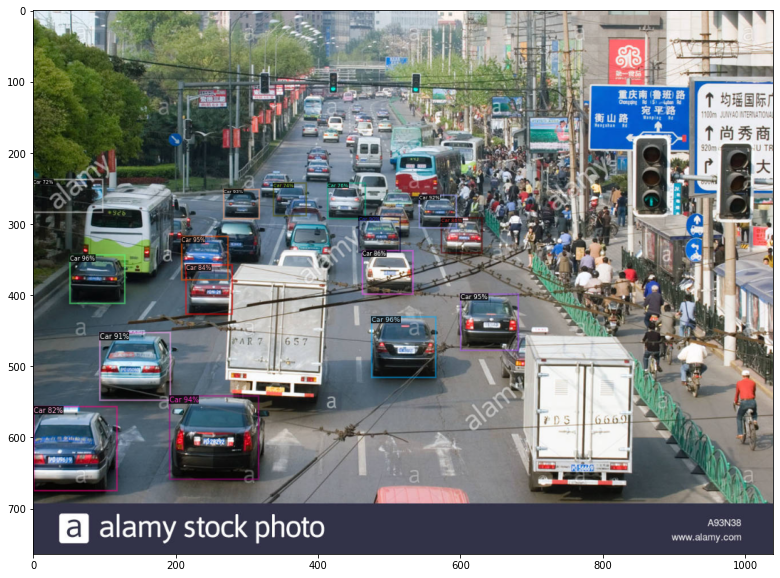

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
from detectron2.utils.visualizer import ColorMode
import random
import numpy as np
import os
from google.colab import files

uploaded=files.upload()

for fn in uploaded.keys():
  path='/content/drive/My Drive/'+fn
  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("/content/drive/My Drive" )
predictor = DefaultPredictor(cfg)

im = cv2.imread(path)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata=vehicle_detection_metadata, scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()